# Load LLM, SAEs

sae layers: [7, 14, 21, 28, 40]
llm gemma 9b

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
import circuitsvis as cv
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
import tqdm
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import functools
import pandas as pd


# device= 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.set_default_device(device)
# assert device == 'cuda', "This notebook is not optimized for CPU"

import transformer_lens

# Load a model
model = transformer_lens.HookedTransformer.from_pretrained("gemma-2-9b", device="cuda")
pad_token_id = model.tokenizer.pad_token_id
print('pad token id is', pad_token_id)

for param in model.parameters():
   param.requires_grad_(False)

device = "cuda"



Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b into HookedTransformer
pad token id is 0


In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"


In [3]:
from sae_lens import SAE, HookedSAETransformer
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

In [4]:
# import signal
# import torch.nn as nn
# class KeyboardInterruptBlocker:
#     def __enter__(self):
#         # Ignore SIGINT (KeyboardInterrupt) and save the old handler
#         self.original_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
#     def __exit__(self, exc_type, exc_value, traceback):
#         # Restore the original SIGINT handler
#         signal.signal(signal.SIGINT, self.original_handler)
# class SparseMask(nn.Module):
#     def __init__(self, shape, l1, seq_len=None):
#         super().__init__()
#         if seq_len is not None:
#             self.mask = nn.Parameter(torch.ones(seq_len, shape))
#         else:
#             self.mask = nn.Parameter(torch.ones(shape))
#         self.l1 = l1
#         self.max_temp = torch.tensor(1000.0)
#         self.sparsity_loss = None
#         self.ratio_trained = 1
#         self.temperature = 1
#     def forward(self, x, binary=False, mean_ablation=None):
#         if binary and mean_ablation is not None:
#             binarized = (self.mask > 0).float().to(x.device)
#             return x * binarized + mean_ablation * (~binarized.bool())
#         if binary:
#             # binary mask, 0 if negative, 1 if positive
#             binarized = (self.mask > 0).float()
#             return x * binarized
#         self.temperature = self.max_temp ** self.ratio_trained
#         mask = torch.sigmoid(self.mask * self.temperature)
#         self.sparsity_loss = torch.abs(mask).sum() * self.l1
#         if mean_ablation is None:
#             return x * mask
#         else:
#             return x * mask + mean_ablation * (~mask.bool())
# # for sae in saes:
# #     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=67)



# Load Dataset

In [5]:
# Updated version to return JSON with more names and structure for correct and incorrect keying examples

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
    
    
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

# Output the JSON structure


In [6]:
simple_dataset_ex_len = 65

In [7]:
json_dataset[0]

{'correct': {'prompt': 'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'Megan\': 10, \'Grace\': 16, \'Liam\': 18, \'Sally\': 10, \'Emily\': 11}\n>>> age["Liam"]\n',
  'response': 18,
  'token': '1'},
 'error': {'prompt': 'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'Megan\': 10, \'Grace\': 16, \'Liam\': 18, \'Sally\': 10, \'Emily\': 11}\n>>> age["Sophia"]\n',
  'response': 'Traceback',
  'token': 'Traceback'}}

In [8]:
tokenized = model.to_tokens(["I like pie", "I like cake and pie", "birds", 'cats'])
torch.count_nonzero(tokenized != pad_token_id, dim=-1)-1
tokenized


tensor([[     2, 235285,   1154,   4506,      0,      0],
        [     2, 235285,   1154,  11514,    578,   4506],
        [     2,  39954,      0,      0,      0,      0],
        [     2,  34371,      0,      0,      0,      0]], device='cuda:0')

In [9]:
tensa = torch.tensor([1,2,3,])
tesb = torch.tensor([1,2,3,4])
torch.cat([tensa, tesb])

tensor([1, 2, 3, 1, 2, 3, 4], device='cuda:0')

In [10]:
class ContrastiveDatasetBatch:
    def __init__(self, dataset_items):
        self.correct_batch = [item["correct"] for item in dataset_items]
        self.error_batch = [item["error"] for item in dataset_items]
        self.batch_size = len(self.correct_batch)
        self.correct_token_idx = model.to_single_token("1")
        self.error_token_idx = model.to_single_token("Traceback")

        correct_tokenized = None
        error_tokenized = None

        correct_prompts = [example["prompt"] for example in self.correct_batch]
        error_prompts = [example["prompt"] for example in self.error_batch]
        assert len(correct_prompts) == len(error_prompts)
        all_prompts = correct_prompts + error_prompts
        all_tokenized = model.to_tokens(all_prompts)
        last_non_pad_idxs = torch.count_nonzero(all_tokenized != pad_token_id, dim=-1) - 1


        correct_tokenized = all_tokenized[:self.batch_size]
        correct_answer_idxs = last_non_pad_idxs[:self.batch_size]
        error_tokenized = all_tokenized[self.batch_size:]
        error_answer_idxs = last_non_pad_idxs[self.batch_size:]

        self.correct_tokenized = correct_tokenized
        self.error_tokenized = error_tokenized
        self.correct_answer_seq_idxs = correct_answer_idxs
        self.error_answer_seq_idxs = error_answer_idxs

        self.all_tokenized = all_tokenized
        self.all_answer_seq_idxs = last_non_pad_idxs
        self.all_prompts = all_prompts
        # the tokens are: [correct prompt, correct prompt, ..., error prompt, error prompt, ...]
        self.all_answers_tok_idxs = torch.cat(
            [
                torch.ones(self.batch_size, dtype=torch.int64)*self.correct_token_idx,
                torch.ones(self.batch_size, dtype=torch.int64)*self.error_token_idx
            ]
            )
        self.all_wrong_answers_tok_idxs = torch.cat(
            [
                torch.ones(self.batch_size, dtype=torch.int64)*self.error_token_idx,
                torch.ones(self.batch_size, dtype=torch.int64)*self.correct_token_idx
            ]
            )
    
    def get_logit_diffs(self, clean_logits, error_logits):
        # for the clean pass, get the logit for the "1" token and the "Traceback" token
        correct_code_right_logits = clean_logits[torch.arange(self.batch_size), self.correct_answer_seq_idxs, self.correct_token_idx]
        correct_code_wrong_logits = clean_logits[torch.arange(self.batch_size), self.correct_answer_seq_idxs, self.error_token_idx]
        correct_logit_diffs = correct_code_right_logits - correct_code_wrong_logits

        # for the error pass, get the logit for the Traceback token and the "1" token
        error_code_right_logits = error_logits[torch.arange(self.batch_size), self.error_answer_seq_idxs, self.error_token_idx]
        error_code_wrong_logits = error_logits[torch.arange(self.batch_size), self.error_answer_seq_idxs, self.correct_token_idx]
        error_logit_diffs = error_code_right_logits - error_code_wrong_logits
        return {"correct_code_diff": correct_logit_diffs, "error_code_diff": error_logit_diffs}
        


eval_dataset = ContrastiveDatasetBatch(json_dataset[:10])

In [11]:
simple_dataset = []
simple_labels = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset:
    simple_dataset.append(item["correct"]["prompt"])
    simple_dataset.append(item["error"]["prompt"])
    simple_labels.append(answer_token)
    simple_labels.append(traceback_token)


simple_dataset = model.to_tokens(simple_dataset)
simple_labels = torch.tensor(simple_labels)



In [12]:
permutation = torch.randperm(len(simple_dataset))
simple_dataset = simple_dataset[permutation]
simple_labels = simple_labels[permutation]

In [13]:
print(f"token:'{model.to_str_tokens(eval_dataset.all_tokenized[15])[eval_dataset.all_answer_seq_idxs[15]]}'")
print("Answer:")
model.to_string([eval_dataset.all_answers_tok_idxs[15]])

token:'
'
Answer:


'Traceback'

# Helper Fns

In [14]:
import signal

class KeyboardInterruptBlocker:
    def __enter__(self):
        # Ignore SIGINT (KeyboardInterrupt) and save the old handler
        self.original_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore the original SIGINT handler
        signal.signal(signal.SIGINT, self.original_handler)


In [15]:
class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        self.sparsity_loss = torch.abs(mask).sum() * self.l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation



for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)
# saes[0].mask = SparseMask(saes[0].cfg.d_sae, 1.0)
# saes[1].mask = SparseMask(saes[1].cfg.d_sae, 1.0)



In [16]:
saes[3].mask.mask.shape

torch.Size([65, 16384])

In [17]:
def apply_mask(mask_idxs, sae):
    mask = torch.full_like(sae.mask.mask, -10)
    mask[mask_idxs] = 10
    sae.mask.mask.data = mask

In [18]:
def load_sparsemask(mask_path):
    json_mask = json.load(open(mask_path))
    for sae in saes:
        apply_mask(json_mask[sae.cfg.hook_name], sae)
    

In [19]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(sae, sequence, cache_grads=False, circuit_mask=None, use_mask=False, binarize_mask=False, cache_masked_activations=False, cache_sae_activations=False,  mean_mask=False, mean_ablate=False): # mean_ablate mean ablates the SAE
    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        if cache_grads:
            sae.feature_acts = feature_acts
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        # apply the mask, with configurable options
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        if circuit_mask is not None:
            mask_method = circuit_mask['mask_method']
            mask_indices = circuit_mask[sae.cfg.hook_name]
            if mask_method == 'keep_only':
                # any activations not in the mask are set to 0
                expanded_circuit_mask = torch.zeros_like(feature_acts)
                expanded_circuit_mask[:, :, mask_indices] = 1
                feature_acts = feature_acts * expanded_circuit_mask
            elif mask_method == 'zero_only':
                feature_acts[:, :, mask_indices] = 0
            else:
                raise ValueError(f"mask_method {mask_method} not recognized")
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook


    # def sae_hook_ablate(value, hook):
    # feature_acts = sae.encode(value)
    # # feature_acts[:, :, topsae_attr_indices] = 0
    # out = sae.decode(feature_acts)
    # return out


def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False, # mean_ablate mean ablates the entire SAE regardless of the mask.
                    ):
    hooks = []
    # blocks.0.hook_resid_pre
    # # fake hook that adds zero so gradients propagate through the model
    param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    hooks.append(
        (
            "blocks.0.hook_resid_pre",
            lambda value, hook: value + param,
        )
    )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate),
            )
        )
    return hooks 

In [20]:
def sanity_check_model_performance(logitfn):
    baseline_dataset = ContrastiveDatasetBatch(json_dataset[-10:])
    correct_logits = logitfn(baseline_dataset.correct_tokenized)
    error_logits = logitfn(baseline_dataset.error_tokenized)
    print("probability of predicting the correct age in the correct example")
    print(F.softmax(correct_logits[torch.arange(correct_logits.shape[0]), baseline_dataset.correct_answer_seq_idxs], dim=-1)[:, baseline_dataset.correct_token_idx].mean())
    print("and of traceback in that example")
    print(F.softmax(correct_logits[torch.arange(correct_logits.shape[0]), baseline_dataset.correct_answer_seq_idxs], dim=-1)[:, baseline_dataset.error_token_idx].mean())
    print("logit difference:")
    correct_logit_values = correct_logits[torch.arange(correct_logits.shape[0]), baseline_dataset.correct_answer_seq_idxs, baseline_dataset.correct_token_idx]
    error_logit_values = correct_logits[torch.arange(correct_logits.shape[0]), baseline_dataset.correct_answer_seq_idxs, baseline_dataset.error_token_idx]
    diff = correct_logit_values - error_logit_values
    print(diff.mean())

    print("probability of predicting the traceback in the error code example")
    print(F.softmax(error_logits[torch.arange(error_logits.shape[0]), baseline_dataset.error_answer_seq_idxs], dim=-1)[:, baseline_dataset.error_token_idx].mean())
    print("and of the correct age in that example")
    print(F.softmax(error_logits[torch.arange(error_logits.shape[0]), baseline_dataset.error_answer_seq_idxs], dim=-1)[:, baseline_dataset.correct_token_idx].mean())    
    print("logit difference:")
    correct_logit_values = error_logits[torch.arange(error_logits.shape[0]), baseline_dataset.error_answer_seq_idxs, baseline_dataset.error_token_idx]
    error_logit_values = error_logits[torch.arange(error_logits.shape[0]), baseline_dataset.error_answer_seq_idxs, baseline_dataset.correct_token_idx]
    diff = correct_logit_values - error_logit_values
    print(diff.mean())


In [21]:
def sanity_check_model_performance(logitfn):
    baseline_dataset = ContrastiveDatasetBatch(json_dataset[-10:])
    correct_logits = logitfn(baseline_dataset.correct_tokenized)
    error_logits = logitfn(baseline_dataset.error_tokenized)
    
    # Initialize a results dictionary with shorter keys
    results = {}
    
    # Compute probabilities for the correct example
    correct_probs = F.softmax(
        correct_logits[torch.arange(correct_logits.shape[0]), baseline_dataset.correct_answer_seq_idxs],
        dim=-1
    )
    prob_correct_in_correct = correct_probs[:, baseline_dataset.correct_token_idx].mean().item()
    prob_error_in_correct = correct_probs[:, baseline_dataset.error_token_idx].mean().item()
    correct_logit_values = correct_logits[
        torch.arange(correct_logits.shape[0]),
        baseline_dataset.correct_answer_seq_idxs,
        baseline_dataset.correct_token_idx
    ]
    error_logit_values = correct_logits[
        torch.arange(correct_logits.shape[0]),
        baseline_dataset.correct_answer_seq_idxs,
        baseline_dataset.error_token_idx
    ]
    logit_diff_correct = (correct_logit_values - error_logit_values).mean().item()
    
    # Store results for the correct example
    results['prob_correct_in_correct'] = prob_correct_in_correct
    results['prob_error_in_correct'] = prob_error_in_correct
    results['logit_diff_correct'] = logit_diff_correct
    
    # Compute probabilities for the error example
    error_probs = F.softmax(
        error_logits[torch.arange(error_logits.shape[0]), baseline_dataset.error_answer_seq_idxs],
        dim=-1
    )
    prob_error_in_error = error_probs[:, baseline_dataset.error_token_idx].mean().item()
    prob_correct_in_error = error_probs[:, baseline_dataset.correct_token_idx].mean().item()
    correct_logit_values_error = error_logits[
        torch.arange(error_logits.shape[0]),
        baseline_dataset.error_answer_seq_idxs,
        baseline_dataset.error_token_idx
    ]
    error_logit_values_error = error_logits[
        torch.arange(error_logits.shape[0]),
        baseline_dataset.error_answer_seq_idxs,
        baseline_dataset.correct_token_idx
    ]
    logit_diff_error = (correct_logit_values_error - error_logit_values_error).mean().item()
    
    # Store results for the error example
    results['prob_error_in_error'] = prob_error_in_error
    results['prob_correct_in_error'] = prob_correct_in_error
    results['logit_diff_error'] = logit_diff_error
    
    return results


In [22]:
def all_contrastive_difference(logitfn):
    baseline_dataset = ContrastiveDatasetBatch(json_dataset[0:10])
    all_tokenized = baseline_dataset.all_tokenized
    all_answer_seq_idxs = baseline_dataset.all_answer_seq_idxs
    all_answers_tok_idxs = baseline_dataset.all_answers_tok_idxs
    all_wrong_answers_tok_idxs = baseline_dataset.all_wrong_answers_tok_idxs
    all_prompts = baseline_dataset.all_prompts
    
    all_logits = logitfn(all_tokenized)
    all_answer_logits = all_logits[torch.arange(all_logits.shape[0]), all_answer_seq_idxs]
    all_answers_correct_logits = all_answer_logits[torch.arange(all_answer_logits.shape[0]), all_answers_tok_idxs]
    all_answers_wrong_logits = all_answer_logits[torch.arange(all_answer_logits.shape[0]), all_wrong_answers_tok_idxs]
    all_logit_diffs = all_answers_correct_logits - all_answers_wrong_logits
    # 6.7 dif for correct, 1.8 for error
    all_logit_diffs[0:baseline_dataset.batch_size] = all_logit_diffs[0:baseline_dataset.batch_size]/6.7
    all_logit_diffs[baseline_dataset.batch_size:] = all_logit_diffs[baseline_dataset.batch_size:]/1.8
    return all_logit_diffs



# SAE vs no SAE (sanity check and basic setup)

In [23]:
baseline_dataset = ContrastiveDatasetBatch(json_dataset[10:15])

In [24]:
def baseline_model_logit_fn(tokens):
    correct_logits = model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=[
            #(
            #utils.get_act_name("pre", 0), # v=attention out
            #"blocks.0.hook_mlp_out",
            #mlp_ablation_hook,
            #),
            ]
        )
    return correct_logits

with torch.no_grad():
    sanity_check_model_performance(baseline_model_logit_fn)

In [25]:
pad_token_id
bos_token_id = model.tokenizer.bos_token_id
bos_token_id

2

In [26]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    sanity_check_model_performance(logitfn)

In [27]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    logits = logitfn(baseline_dataset.error_tokenized)

In [28]:
test_idx = 4
topk = torch.topk(logits[:, -1, :][test_idx], k=3)
print(model.to_str_tokens(topk.indices))
print(topk.values)
logits[:, -1, :][test_idx][baseline_dataset.correct_token_idx]

['>>>', 'Traceback', 'print']
tensor([25.8636, 25.4394, 24.8588], device='cuda:0')


tensor(24.1308, device='cuda:0')

# Contrastive Logit Diff With Positive and Negative

In [29]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    all_logit_diffs = all_contrastive_difference(logitfn)
    print(all_logit_diffs)

tensor([1.0415, 0.9522, 1.0375, 1.1017, 1.0306, 1.0303, 1.0525, 0.9940, 1.1501,
        0.9840, 0.8197, 1.1012, 1.5776, 0.9999, 1.5780, 0.8209, 0.8822, 1.0724,
        1.4219, 1.0966], device='cuda:0')


# Attribution

In [30]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, cache_sae_grads=True)
        )

all_logit_diffs = all_contrastive_difference(logitfn)

In [31]:
loss = all_logit_diffs.sum() * -1 # maximize the difference

In [32]:
loss.backward()

In [33]:
loss

tensor(-21.7448, device='cuda:0', grad_fn=<MulBackward0>)

In [34]:
no_ablate = {"mask_method": "keep_only"}

In [35]:
num_features = saes[0].cfg.d_sae

In [36]:
with torch.no_grad():
    for sae in saes:
        delta_loss = torch.abs((sae.feature_acts.grad * sae.feature_acts).view(-1, sae.feature_acts.shape[-1]).sum(dim=0))
        topk = torch.topk(delta_loss, k=63)
        no_ablate[sae.cfg.hook_name] = topk.indices

In [37]:
import random
# deep copy
import copy
random_ablate = copy.deepcopy(no_ablate)

num_features = saes[0].cfg.d_sae

for key in random_ablate.keys():
    if key == "mask_method":
        continue
#     for i in range(len(random_ablate[key])):
#         random_ablate[key][i] = random.randint(0, num_features-1)
# random_ablate

In [38]:
# test the ablation
    
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(
                tokens,
                cache_sae_grads=False,
                circuit_mask=no_ablate)
            )
    
    all_logit_diffs = sanity_check_model_performance(logitfn)
    #all_logit_diffs = san(logitfn).mean()
    # print(all_logit_diffs)

# Collect SAE Means

In [39]:
# for each SAE create a sae_dim float32 with mean latent activation over subset of datset
batch_size = 16
num_batches = 10
num_features = saes[0].cfg.d_sae

In [58]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, cache_sae_activations=True)
        )

def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

# # test running mean tensor
# test_data = torch.arange(3).float()
# test_data

# data_examples = []
# for i in range(30):
#     # add noise to the data
#     data_examples.append(test_data + torch.randn_like(test_data)*0.1)

# running_mean = torch.zeros_like(test_data)
# for i, data in enumerate(data_examples):
#     running_mean = running_mean_tensor(running_mean, data, i+1)
#     print(running_mean)

tok1 = traceback_token
tok2 = answer_token


all_fwd_passes = []
def get_sae_means(total_steps, per_token_mask=False, keep_only='none'):
    all_optimized_params = []
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float()
    
    with tqdm.tqdm(total=total_steps, desc="Mean Accum Progress") as pbar:
        for i, (x, y) in enumerate(zip(simple_dataset, simple_labels)):
            if keep_only == 'traceback' and y != traceback_token:
                continue
            if keep_only == 'correct' and y != answer_token:
                continue

            with torch.no_grad():
                logits = logitfn(x)
                for sae in saes:
                    sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
            pbar.update(1)

            if i >= total_steps:
                break

get_sae_means(50*16, keep_only='none')


# # this won't work anymore b/c I removed mean_ablate
# def mean_ablated_logitfn(tokens):
#     return model.run_with_hooks(
#         tokens, 
#         return_type="logits", 
#         fwd_hooks=build_hooks_list(tokens, mean_ablate=True)
#         )

# # all_contrastive_difference
# sanity_check_model_performance(mean_ablated_logitfn)

Mean Accum Progress: 801it [01:59,  6.68it/s]                         


In [44]:
for sae in saes:
    sae.mean_ablation = sae.mean_ablation.squeeze()

### Jatin's code for mean ablation

In [60]:
clean_dataset = []
corr_dataset = []
clean_labels = []
corr_labels = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset:
    clean_dataset.append(item["error"]["prompt"])
    corr_dataset.append(item["correct"]["prompt"])
    clean_labels.append(traceback_token)
    corr_labels.append(answer_token)


clean_tok_dataset = model.to_tokens(clean_dataset)
clean_labels = torch.tensor(clean_labels)

corr_tok_dataset = model.to_tokens(corr_dataset)
corr_labels = torch.tensor(corr_labels)

permutation = torch.randperm(len(clean_tok_dataset))
clean_tok_dataset = clean_tok_dataset[permutation]
clean_labels = clean_labels[permutation]

corr_tok_dataset = corr_tok_dataset[permutation]
corr_labels = corr_labels[permutation]



from tqdm import tqdm
def running_mean_tensor(old_mean, new_value, n):
    """Update the running mean tensor using the current batch."""
    return old_mean + (new_value - old_mean) / n
def get_sae_means(saes, dataset, total_steps, batch_size=16):
    """
    Compute token-level means across the dataset in a batched manner.
    Args:
        dataset (Tensor): The input dataset of tokenized data.
        total_steps (int): Number of steps to process.
        batch_size (int): Number of examples per batch.
    """
    for sae in saes:
        # Initialize mean_ablation with correct shape
        sae.mean_ablation = torch.zeros((dataset[0].shape[0], sae.cfg.d_sae)).float().to(device)
    total_samples = len(dataset)
    num_batches = (total_samples + batch_size - 1) // batch_size  # Calculate number of batches
    with tqdm(total=min(total_steps, num_batches), desc="Mean Accum Progress") as pbar:
        sample_count = 0  # To track total number of samples processed
        for i in range(0, total_samples, batch_size):
            # Batch selection
            batch_x = dataset[i:i+batch_size]
            with torch.no_grad():
                logits = logitfn(batch_x)  # Get logits (forward pass)
                for sae in saes:
                    # Compute batch mean over tokens
                    batch_mean = sae.feature_acts.mean(dim=0)  # Mean across the batch
                    sample_count +=  1 # len(batch_x)  # Update sample count
                    # Update running mean tensor
                    sae.mean_ablation = running_mean_tensor(
                        sae.mean_ablation,
                        batch_mean,
                        sample_count
                    )
            pbar.update(1)  # Update progress bar
            # Stop if we've processed enough steps
            if i // batch_size >= total_steps:
                break

get_sae_means(saes, corr_tok_dataset, 50, batch_size=16)

Mean Accum Progress: 51it [00:38,  1.33it/s]                        


In [52]:
saes[0].mean_ablation.shape

torch.Size([1, 65, 16384])

In [ ]:
# NOTE: If you run the rest of the code it adds a batch dim to this data, and this code is screwed
def mean_ablated_logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, mean_ablate=True)
        )

# all_contrastive_difference
sanity_check_model_performance(mean_ablated_logitfn)

{'prob_correct_in_correct': 0.9518125653266907,
 'prob_error_in_correct': 0.00013982107338961214,
 'logit_diff_correct': 8.825759887695312,
 'prob_error_in_error': 0.00013982107338961214,
 'prob_correct_in_error': 0.9518125653266907,
 'logit_diff_error': -8.825759887695312}

# Optimize Binary Mask

In [87]:
batch_size = 16

# makethe length of the dataset a multiple of the batch size
simple_dataset = simple_dataset[:batch_size*(len(simple_dataset)//batch_size)]
simple_labels = simple_labels[:batch_size*(len(simple_labels)//batch_size)]

simple_dataset = simple_dataset.view(-1, batch_size, 65)
simple_labels = simple_labels.view(-1, batch_size)


In [88]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True)
        )


def forward_pass(batch, labels, logitfn, ratio_trained=1):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)

    return loss, sparsity_loss

In [89]:

import wandb
from tqdm import tqdm




def do_training_run(sparsity_multiplier, per_token_mask=False, use_mask=False, mean_mask=False):

    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )

    def forward_pass(batch, labels, logitfn, ratio_trained=1):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)

        return loss, sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 0.05,
        "total_steps": simple_dataset.shape[0]*0.01,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"]

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for i, (x, y) in enumerate(zip(simple_dataset, simple_labels)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained = i / total_steps
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss = forward_pass(x, y, logitfn, ratio_trained=ratio_trained)
                if per_token_mask:
                    sparsity_loss = sparsity_loss / 65

                avg_nonzero_elements = sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"]
                total_loss = loss + sparsity_loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature}
                wandb.log(infodict)
                
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                if i >= total_steps*1.3:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(torch.sigmoid(sae.mask.mask*10000))[0].tolist()
        total_density += torch.sigmoid(sae.mask.mask*10000).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)
    print(mask_dict['avg_density'])

    ### EVAL ###
    def masked_logit_fn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)

        # sparsity_loss = 0
        # for sae in saes:
        #     sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
        
        # sparsity_loss = sparsity_loss / len(saes)

        return loss

    with torch.no_grad():
        loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
        print("CE loss:", loss)

    mask_dict['ce_loss'] = loss.item()


    json.dump(mask_dict, open(f"{str(sparsity_multiplier)}_run.json", "w"))
    
    

In [90]:
def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )

def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)

    # sparsity_loss = 0
    # for sae in saes:
    #     sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    # sparsity_loss = sparsity_loss / len(saes)

    return loss

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[30], simple_labels[30], masked_logit_fn)
    print("CE loss:", loss)



CE loss: tensor(18.4099, device='cuda:0')


In [91]:
do_training_run(0.025, per_token_mask=False, use_mask=True, mean_mask=True)

wandb: Currently logged in as: jcaples4 (llm-research-activated). Use `wandb login --relogin` to force relogin


doing a run with sparsity multiplier 0.025


Training Progress:  99%|█████████▉| 124/124.96000000000001 [03:29<00:01,  1.69s/it, Step=124, Progress=0.992, Avg Nonzero Elements=117, Task Loss=0.503, Sparsity Loss=2.92, temperature=tensor(192.0226, device='cuda:0')]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 164it [04:34,  1.68s/it, Step=163, Progress=1.3, Avg Nonzero Elements=117, Task Loss=0.589, Sparsity Loss=2.92, temperature=tensor(1003.4679, device='cuda:0')]                                         


Avg Nonzero Elements,██▇▇▇▆▆▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
Sparsity Loss,█████▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇████
Task Loss,█▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▅▅▆▆█
Avg Nonzero Elements,116.75
Progress,1.30442
Sparsity Loss,2.91875
Step,163
Task Loss,0.5887


116.75
CE loss: tensor(0.5731, device='cuda:0')


In [92]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )

# def forward_pass(batch, labels, logitfn, ratio_trained=1):
#     for sae in saes:
#         sae.mask.ratio_trained = ratio_trained
#     tokens = batch
#     logits = logitfn(tokens)
#     last_token_logits = logits[:, -1, :]
#     loss = F.cross_entropy(last_token_logits, labels)
#     sparsity_loss = 0
#     for sae in saes:
#         sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
#     sparsity_loss = sparsity_loss / len(saes)

    return loss, sparsity_loss
with torch.no_grad():
    idx = 4
    print("original example")
    print(f"{model.to_string(simple_dataset[-1][idx])}")
    print("original label")
    print(model.to_string(simple_labels[-1][idx:idx+1]))
    logits = logitfn(simple_dataset[-1][idx:idx+1][-1])[-1][-1]
    print(logits.shape)
    probs = F.softmax(logits, dim=-1)
    print(probs.shape)
    # get the top 3 tokens and their probabilities
    topk = torch.topk(probs, k=3)
    print(model.to_str_tokens(topk.indices))
    print(topk.values)
    # get the cross entropy loss
    loss = F.cross_entropy(logits.unsqueeze(0), simple_labels[-1][idx:idx+1])
    print(f"ce loss {loss}")


original example
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Liam': 17, 'Emily': 17, 'Mia': 17, 'Sophia': 17, 'Ethan': 11}
>>> age["Liam"]

original label
1
torch.Size([256000])
torch.Size([256000])
['1', 'Traceback', '>>>']
tensor([0.6384, 0.2210, 0.0217], device='cuda:0')
ce loss 0.44883954524993896


In [ ]:
# ?????
# testmask = saes[0].mask.mask.data.clone()

# binarized = (testmask > 0.5).float()

# print(torch.count_nonzero(binarized))

# tokens = model.to_str_tokens(simple_dataset[2][0])
# for i in range(65):
#     print(f"Token {i}:", tokens[i], torch.count_nonzero(binarized[i]).item())

tensor(4, device='cuda:0')
Token 0: <bos> 0
Token 1: Type 0
Token 2:  " 0
Token 3: help 0
Token 4: ", 0
Token 5:  " 0
Token 6: copyright 0
Token 7: ", 0
Token 8:  " 0
Token 9: credits 0
Token 10: " 0
Token 11:  or 0
Token 12:  " 0
Token 13: license 0
Token 14: " 0
Token 15:  for 0
Token 16:  more 0
Token 17:  information 0
Token 18: . 0
Token 19: 
 0
Token 20: >>> 0
Token 21:  age 0
Token 22:  = 0
Token 23:  {' 0
Token 24: Olivia 0
Token 25: ': 0
Token 26:   0
Token 27: 1 0
Token 28: 8 0
Token 29: , 0
Token 30:  ' 0
Token 31: Sophia 0
Token 32: ': 0
Token 33:   0
Token 34: 1 0
Token 35: 4 0
Token 36: , 0
Token 37:  ' 0
Token 38: Ava 0
Token 39: ': 0
Token 40:   0
Token 41: 1 0
Token 42: 8 0
Token 43: , 0
Token 44:  ' 0
Token 45: Emma 0
Token 46: ': 0
Token 47:   0
Token 48: 1 0
Token 49: 7 0
Token 50: , 0
Token 51:  ' 0
Token 52: Oliver 0
Token 53: ': 0
Token 54:   0
Token 55: 1 0
Token 56: 1 0
Token 57: } 0
Token 58: 
 0
Token 59: >>> 0
Token 60:  age 0
Token 61: [" 0
Token 62: Chris 

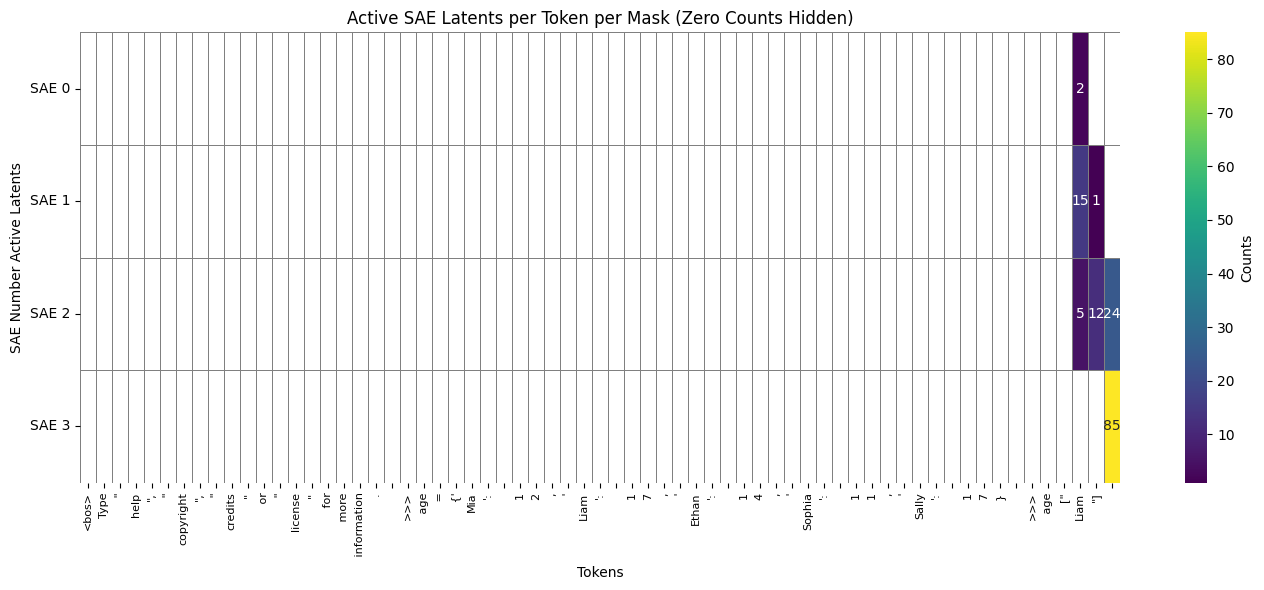

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(simple_dataset[2][0])
num_masks = 4  # Number of masks you have
counts_per_mask = []

for mask_index in range(num_masks):
    testmask = saes[mask_index].mask.mask.data.clone()
    binarized = (testmask > 0.5).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask)  # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Create a custom colormap that starts from a color for the lowest non-zero value
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()


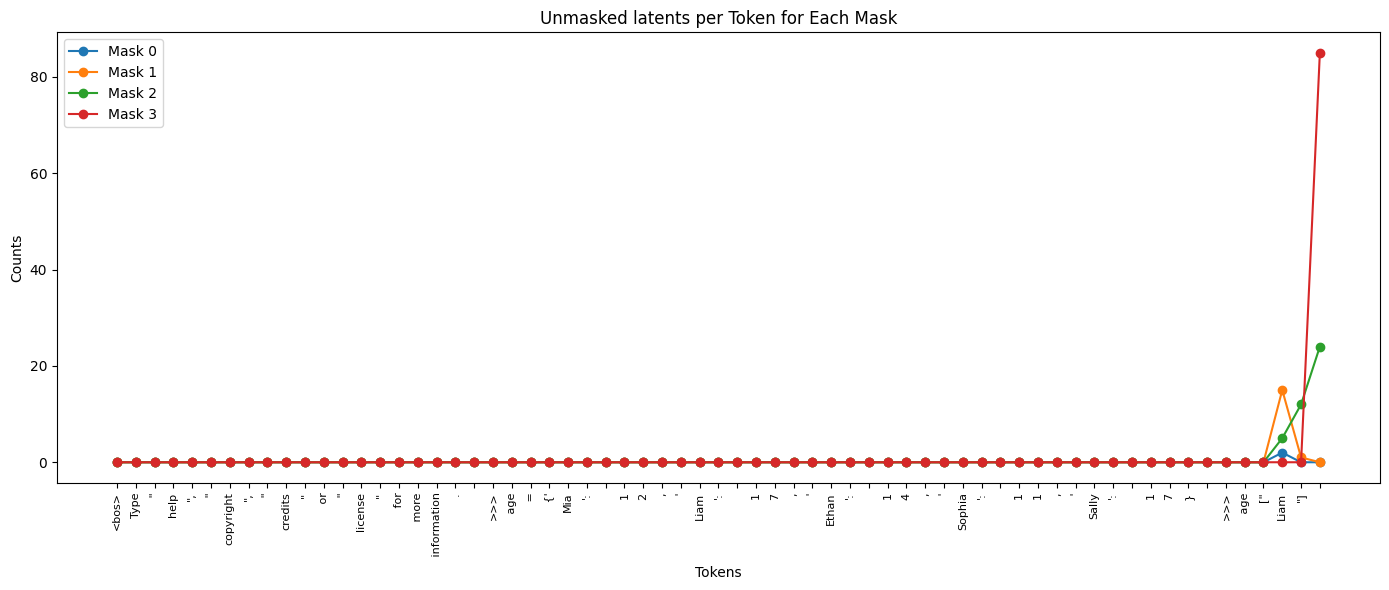

In [ ]:
# Positions of the tokens on the x-axis
x = np.arange(len(tokens))

plt.figure(figsize=(14, 6))

# Plot counts for each mask
for mask_index in range(num_masks):
    y = counts_per_mask[mask_index]
    plt.plot(x, y, marker='o', label=f'Mask {mask_index}')

# Set x-axis labels to tokens
plt.xticks(x, tokens, rotation=90, fontsize=8)
plt.xlabel('Tokens')
plt.ylabel('Counts')
plt.title('Unmasked latents per Token for Each Mask')
plt.legend()
plt.tight_layout()
plt.show()


['<bos>',
 'Type',
 ' "',
 'help',
 '",',
 ' "',
 'copyright',
 '",',
 ' "',
 'credits',
 '"',
 ' or',
 ' "',
 'license',
 '"',
 ' for',
 ' more',
 ' information',
 '.',
 '\n',
 '>>>',
 ' age',
 ' =',
 " {'",
 'Lucas',
 "':",
 ' ',
 '1',
 '5',
 ',',
 " '",
 'James',
 "':",
 ' ',
 '1',
 '6',
 ',',
 " '",
 'Megan',
 "':",
 ' ',
 '1',
 '1',
 ',',
 " '",
 'Emma',
 "':",
 ' ',
 '1',
 '7',
 ',',
 " '",
 'Oliver',
 "':",
 ' ',
 '1',
 '3',
 '}',
 '\n',
 '>>>',
 ' age',
 '["',
 'Benjamin',
 '"]',
 '\n']

In [ ]:
torch.sigmoid(saes[0].mask.mask[0])

tensor([-1.3649, -1.3649, -1.3649,  ..., -1.3649, -1.3649, -1.3649],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
for sae in saes:
    for param in sae.parameters():
        param.grad = None
    for param in sae.mask.parameters():
        param.grad = None

for param in model.parameters():
    param.grad = None

torch.cuda.empty_cache()


## HPRAM sweep

In [ ]:
1/25

0.04

In [ ]:
# 1/10 -> 1/100
num_runs = 10

start = 1/15
end = 1/100
step = (end-start)/num_runs

for i in range(num_runs):
    sparsity_multiplier = start + i*step
    print(f"Starting run with sparsity multiplier {sparsity_multiplier}")
    do_training_run(sparsity_multiplier)

Starting run with sparsity multiplier 0.06666666666666667
doing a run with sparsity multiplier 0.06666666666666667


Training Progress:   5%|▍         | 6/125.0 [00:10<03:28,  1.75s/it, Step=5, Progress=0.04, Avg Nonzero Elements=1.17e+4, Task Loss=5.53, Sparsity Loss=783, temperature=tensor(1.2361, device='cuda:0')] 


KeyboardInterrupt: 

## Eval

In [ ]:
def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, binarize_mask=True, mean_mask=True)
        )

In [ ]:
def baseline_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=[]
        )

In [ ]:
def baseline_sae_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens)
        )

In [ ]:
# serialize the masks
mask_dict = {}
for sae in saes:
    mask_dict[sae.cfg.hook_name] = torch.where(torch.sigmoid(sae.mask.mask*10000))[0].tolist()

json.dump(mask_dict, open("mask_dict.json", "w"))
len(mask_dict["blocks.7.hook_resid_post"])

5

In [ ]:
for sae in saes:
    mask = sae.mask.mask
    print(f"Nonzero elements in mask for {sae.cfg.hook_name}: {torch.count_nonzero(torch.sigmoid(mask*1000))}")

Nonzero elements in mask for blocks.7.hook_resid_post: 5
Nonzero elements in mask for blocks.14.hook_resid_post: 13
Nonzero elements in mask for blocks.21.hook_resid_post: 20
Nonzero elements in mask for blocks.40.hook_resid_post: 45


In [ ]:
def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)

    return loss

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_logit_fn)
    print("baseline loss:", loss)

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_sae_logit_fn)
    print("sae loss: ", loss)

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
    print("ablated loss: ", loss)

baseline loss: tensor(0.0276, device='cuda:0')
sae loss:  tensor(0.8250, device='cuda:0')
ablated loss:  tensor(0.4248, device='cuda:0')


In [ ]:
def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    # Assuming 'saes' is defined elsewhere in your code
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss += sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    total_loss = loss + sparsity_loss

    return loss.item()  # Return the loss as a scalar value



In [ ]:
results_list = []

# Method: VANILLA GEMMA 9B
method_name = "VANILLA GEMMA 9B"
with torch.no_grad():
    results = sanity_check_model_performance(baseline_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Method: GEMMA 9B WITH SAE (no masks)
method_name = "GEMMA 9B WITH SAE (no masks)"
with torch.no_grad():
    results = sanity_check_model_performance(baseline_sae_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_sae_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Method: GEMMA 9B WITH SAE Masked
method_name = "GEMMA 9B WITH SAE Masked"
with torch.no_grad():
    results = sanity_check_model_performance(masked_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Create a DataFrame and display it with descriptive column names
df = pd.DataFrame(results_list)
df = df.set_index('method')  # Set 'method' as the index

# Rename columns for better readability
df = df.rename(columns={
    'prob_correct_in_correct': 'P(Age|Correct Ex)',
    'prob_error_in_correct': 'P(Traceback|Correct Ex)',
    'logit_diff_correct': 'Logit Diff (Correct Ex)',
    'prob_error_in_error': 'P(Traceback|Error Ex)',
    'prob_correct_in_error': 'P(Age|Error Ex)',
    'logit_diff_error': 'Logit Diff (Error Ex)',
    'ce_loss': 'Cross-Entropy Loss'
})

# Display the DataFrame
df


,P(Age|Correct Ex),P(Traceback|Correct Ex),Logit Diff (Correct Ex),P(Traceback|Error Ex),P(Age|Error Ex),Logit Diff (Error Ex),Cross-Entropy Loss
method,,,,,,,
VANILLA GEMMA 9B,0.979983,0.001325,6.898462,0.959781,0.000997,6.925329,0.027596
GEMMA 9B WITH SAE (no masks),0.929262,0.001051,6.914926,0.176590,0.025586,2.025202,0.825018
GEMMA 9B WITH SAE Masked,0.828356,0.015461,4.076188,0.469673,0.076615,1.813243,0.424774


# Group features by Correlations

In [ ]:
load_sparsemask("0.025_run.json")

In [ ]:
model.to_str_tokens(example).index("Emily")

24

In [ ]:
model.to_str_tokens(example)[27]


'2'

In [ ]:
model.to_tokens("he was 11")

tensor([[     2,    480,    729, 235248, 235274, 235274]], device='cuda:0')

In [ ]:
example = simple_dataset[-2].clone()
example[27] = 235284 # 2
# example[28] = 235274 # 1
model.to_string(example)


'<bos>Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'Emily\': 27, \'James\': 13, \'Megan\': 17, \'Rob\': 14, \'Sam\': 14}\n>>> age["Emily"]\n'

In [ ]:
# 1. iterate over last 10 examples
data = simple_dataset[-10:]
cached_activations = []
with torch.no_grad():
    def model_forward_pass(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=True, binarize_mask=True, cache_masked_activations=True)
            )
    for example in data:
        logits = model_forward_pass(example)
        cache = {}
        for sae in saes:
            cache[sae.cfg.hook_name] = sae.feature_acts
        cached_activations.append(cache)

    # print(model.to_string(example))
    # logits = model_forward_pass(example)
    # # logits = model_forward_pass(model.to_tokens("The sky is"))
    # print(model.to_str_tokens(torch.topk(F.softmax(logits[:, -1, :], dim=-1), k=3).indices))
    # print(torch.topk(F.softmax(logits[:, -1, :], dim=-1), k=3).values)

In [ ]:
idx = 0
print(torch.where(cached_activations[0]["blocks.7.hook_resid_post"][0][-5]))


print(model.to_string(data[0]))
print(model.to_str_tokens(data[0])[-5])

(tensor([   75,  1575,  3231,  3524,  7008, 10180, 10647, 10768, 11635, 11740,
        12571], device='cuda:0'),)
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Sam': 11, 'Noah': 16, 'Megan': 19, 'Ava': 10, 'Lilly': 17}
>>> age["Noah"]

 age


In [ ]:
cached_activations[0]["blocks.7.hook_resid_post"].shape

torch.Size([1, 65, 16384])

In [ ]:
keep_locations = torch.where(saes[0].mask.mask>0)[0]
print(keep_locations)

tensor([   75,   351,   488,   632,  1229,  1422,  1575,  1589,  1662,  1935,
         1976,  2467,  2701,  2846,  2881,  3153,  3231,  3257,  3354,  3418,
         3524,  3658,  3784,  3992,  4287,  5196,  5311,  5337,  5459,  5537,
         5587,  5778,  6491,  6500,  6535,  6671,  6800,  6928,  6984,  7008,
         7024,  7323,  7857,  7958,  8146,  8667,  8895,  9046,  9052,  9353,
         9513,  9681,  9843,  9850, 10093, 10094, 10180, 10267, 10647, 10680,
        10768, 10868, 11204, 11526, 11635, 11707, 11740, 12131, 12134, 12275,
        12387, 12407, 12571, 12880, 12956, 13383, 13630, 13635, 13694, 14249,
        14309, 14342, 14567, 14615, 14827, 15328, 15462, 15613, 15678, 15738,
        15796], device='cuda:0')


In [ ]:
block_seven_cache = torch.cat([cached_activations[i]["blocks.7.hook_resid_post"] for i in range(10)], dim=0)
block_seven_cache = block_seven_cache[:, 1:, :].contiguous()
block_seven_cache = block_seven_cache.view(-1, block_seven_cache.shape[-1])
block_seven_cache = block_seven_cache[:, keep_locations]

In [ ]:
block_seven_cache

tensor([[18.6473,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [24.8756,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  2.8846],
        [12.3906,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  8.3760],
        ...,
        [16.4783,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [22.2913,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [21.7554,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')